### Necessary import

In [1]:
from lib.datasets import get_gbm
from lib.augmentations import parse_augmentations,apply_augmentations
from lib.network import get_generator, get_discriminator
from lib.model.wgan import WGAN
from lib.model.sigwgan import SigWGAN
from lib.test_metrics import get_standard_test_metrics
from lib.utils import to_numpy,set_seed
from lib.plot import plot_test_metrics, compare_hists
import matplotlib.pyplot as plt
import torch

### Hyperparameter of WGAN and SigWGAN

In [2]:
wgan_config = {
    "batch_size" :1024,
    "epoch" : 3000,  
    "lr_generator" : 1e-3,
    "lr_discriminator" : 3e-3,
    "discriminator_steps_per_generator_step" : 3,
    "augmentations": [
        {"name":  "AddTime"}
    ],
    "device" : "cuda" 
}
wgan_D_config = {
    "discriminator_type": "ResFNN",
    "hidden_dims": [20,20],
}
wgan_logsig_config = {
    "generator_type": "LogSigRNN",
    "hidden_dim": 50,
    "augmentations": [
        {"name":  "AddTime"},
    ],
    "depth": 2,
    "input_dim": 10,
    "len_noise": 1000,
    "len_interval_u": 50,
    "init_fixed": True
}
wgan_lstm_config = {
  "generator_type": "LSTM",
  "hidden_dim": 50,
  "n_layers": 2,
  "init_fixed": True,
  "input_dim": 5
}



set_seed(0)

In [ ]:
sigwgan_config = {
    "batch_size" :512,
    "epoch" : 3000,   
    "lr_generator" : 5e-3,
    "lr_discriminator" : 5e-3,
    "augmentations": [
        {"name":  "AddTime"},
        {"name":  "LeadLag"},
    ],
    "device" : "cuda:0",
    "depth" : 4
}
sigwgan_D_config = {
    "discriminator_type": "ResFNN",
    "hidden_dims": [20,20],
}
sigwgan_logsig_config = {
    "generator_type": "LogSigRNN",
    "hidden_dim": 50,
    "augmentations": [
        {"name":  "AddTime"},
    ],
    "depth": 2,
    "input_dim": 10,
    "len_noise": 1000,
    "len_interval_u": 50,
    "init_fixed": True
}
sigwgan_lstm_config = {
  "generator_type": "LSTM",
  "hidden_dim": 50,
  "n_layers": 2,
  "init_fixed": True,
  "input_dim": 5
}

### Generate GBM paths

In [4]:
GBM_paths = get_gbm(20000, 16, d=3, drift=0.1, scale=0.1, h=1)
print("GBM shape: {}".format(GBM_paths.shape))
x_real_dim = GBM_paths.shape[-1]

GBM shape: torch.Size([20000, 16, 3])


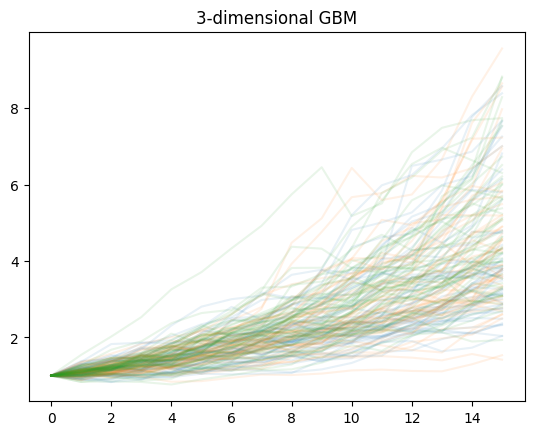

In [9]:
for i in range(x_real_dim):
    plt.plot(to_numpy(GBM_paths[:50, : ,i]).T, 'C%s' % i, alpha=0.1)
plt.title("3-dimensional GBM")
plt.show()

### Set network parameter

In [3]:
if wgan_config.get('augmentations') is not None:
    wgan_config['augmentations'] = parse_augmentations(wgan_config.get('augmentations'))
if wgan_logsig_config.get('augmentations') is not None:
    wgan_logsig_config['augmentations'] = parse_augmentations(wgan_logsig_config.get('augmentations'))

In [ ]:
if sigwgan_config.get('augmentations') is not None:
    sigwgan_config['augmentations'] = parse_augmentations(sigwgan_config.get('augmentations'))
if sigwgan_logsig_config.get('augmentations') is not None:
    sigwgan_logsig_config['augmentations'] = parse_augmentations(sigwgan_logsig_config.get('augmentations'))

In [5]:
y = GBM_paths
if wgan_logsig_config['augmentations'] is not None:
    D_input_dim = apply_augmentations(y,wgan_logsig_config["augmentations"]).shape[2]*16
else: 
    D_input_dim = 30
print("WGAN D input dim: {}".format(D_input_dim))
wgan_D_config.update(input_dim=D_input_dim)
print(wgan_D_config)

wgan_logsig_config.update(output_dim=x_real_dim)
print(wgan_logsig_config)
wgan_lstm_config.update(output_dim=x_real_dim)
print(wgan_lstm_config)

WGAN D input dim: 64
{'discriminator_type': 'ResFNN', 'hidden_dims': [20, 20], 'input_dim': 64}
{'generator_type': 'LogSigRNN', 'hidden_dim': 50, 'augmentations': [AddTime()], 'depth': 2, 'input_dim': 10, 'len_noise': 1000, 'len_interval_u': 50, 'init_fixed': True, 'output_dim': 3}
{'generator_type': 'LSTM', 'hidden_dim': 50, 'n_layers': 2, 'init_fixed': True, 'input_dim': 5, 'output_dim': 3}


In [ ]:
y = GBM_paths
if sigwgan_logsig_config['augmentations'] is not None:
    sigwgan_D_input_dim = apply_augmentations(y,sigwgan_logsig_config["augmentations"]).shape[2]*30
else: 
    sigwgan_D_input_dim = 30
print("SigWGAN D input dim: {}".format(sigwgan_D_input_dim))
sigwgan_D_config.update(input_dim=sigwgan_D_input_dim)
print(sigwgan_D_config)

sigwgan_logsig_config.update(output_dim=x_real_dim)
print(sigwgan_logsig_config)
sigwgan_lstm_config.update(output_dim=x_real_dim)
print(sigwgan_lstm_config)

SigWGAN D input dim: 120
{'discriminator_type': 'ResFNN', 'hidden_dims': [20, 20], 'input_dim': 120}
{'generator_type': 'LogSigRNN', 'hidden_dim': 50, 'augmentations': [AddTime()], 'depth': 2, 'input_dim': 10, 'len_noise': 1000, 'len_interval_u': 50, 'init_fixed': True, 'output_dim': 3}
{'generator_type': 'LSTM', 'hidden_dim': 50, 'n_layers': 2, 'init_fixed': True, 'input_dim': 5, 'output_dim': 3}


### Initialize and run

In [8]:
WGAN_ResFNN = get_discriminator(**wgan_D_config).to(wgan_config['device'])
WGAN_logsig = get_generator(**wgan_logsig_config).to(wgan_config['device'])

WGAN_ResFNN2 = get_discriminator(**wgan_D_config).to(wgan_config['device'])
WGAN_lstm = get_generator(**wgan_lstm_config).to(wgan_config['device'])


LogSigRNN input dim: 11


In [ ]:
SigWGAN_ResFNN = get_discriminator(**sigwgan_D_config).to(sigwgan_config['device'])
SigWGAN_logsig = get_generator(**sigwgan_logsig_config).to(sigwgan_config['device'])

SigWGAN_ResFNN2 = get_discriminator(**sigwgan_D_config).to(sigwgan_config['device'])
SigWGAN_lstm = get_generator(**sigwgan_lstm_config).to(sigwgan_config['device'])

LogSigRNN input dim: 11


In [6]:
# In convenience, x_real_test is set to be the same as x_real_rolled with augmentations.
wgan_x_real_test = apply_augmentations(GBM_paths,wgan_logsig_config["augmentations"])
print("wgan test tensor shape: {}".format(wgan_x_real_test.shape))

wgan_test_metrics = get_standard_test_metrics(wgan_x_real_test)
print("wgantest_metrics_test: {}".format(wgan_test_metrics))

wgan test tensor shape: torch.Size([20000, 16, 4])
wgantest_metrics_test: [SigW1Loss()]


In [ ]:
sigwgan_test_metrics = get_standard_test_metrics(GBM_paths)
print("sigwgantest_metrics_test: {}".format(sigwgan_test_metrics))

sigwgantest_metrics_test: [SigW1Loss()]


In [9]:
Logsig_WGAN = WGAN(WGAN_ResFNN, WGAN_logsig, 
                   x_real=GBM_paths, 
                   test_metrics_test=wgan_test_metrics,
                   **wgan_config
)
Logsig_WGAN.fit(device=wgan_config['device'])

G_loss -1.9468 D_loss -0.0081: 100%|██████████| 650/650 [00:41<00:00, 15.57it/s]


In [9]:
LSTM_WGAN = WGAN(WGAN_ResFNN2, WGAN_lstm, 
                   x_real=GBM_paths, 
                   test_metrics_test=wgan_test_metrics,
                   **wgan_config
)
LSTM_WGAN.fit(device=wgan_config['device'])

  0%|          | 0/3000 [00:00<?, ?it/s]

G_loss 0.6404 D_loss 0.0233: 100%|██████████| 3000/3000 [00:46<00:00, 64.63it/s]  


In [ ]:
logsig_SigWGAN = SigWGAN(SigWGAN_ResFNN,SigWGAN_logsig,x_real_rolled=GBM_paths,
                  test_metrics_test=sigwgan_test_metrics,
                  **sigwgan_config)

logsig_SigWGAN.fit(device=sigwgan_config['device'])

sig-w1 loss: 828.9918: 100%|██████████| 1755/1755 [01:04<00:00, 27.00it/s] 


In [ ]:
lstm_SigWGAN = SigWGAN(SigWGAN_ResFNN2,SigWGAN_lstm,x_real_rolled=GBM_paths,
                  test_metrics_test=sigwgan_test_metrics,
                  **sigwgan_config)
lstm_SigWGAN.fit(device=sigwgan_config['device'])

sig-w1 loss: 836.0599: 100%|██████████| 1755/1755 [00:37<00:00, 46.82it/s] 


### Generated paths

torch.Size([200, 16])


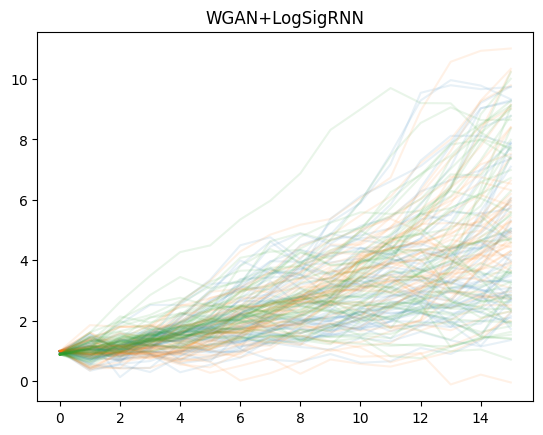

In [10]:
with torch.no_grad():
    wgan_logsig_fake = Logsig_WGAN.G(200, 16, wgan_config['device'])

for i in range(x_real_dim):
    plt.plot(to_numpy(wgan_logsig_fake[:50, :, i]).T, 'C%s' % i, alpha=0.1)
print(wgan_logsig_fake[:200, :, i].shape)
plt.title("WGAN+LogSigRNN")
plt.show()

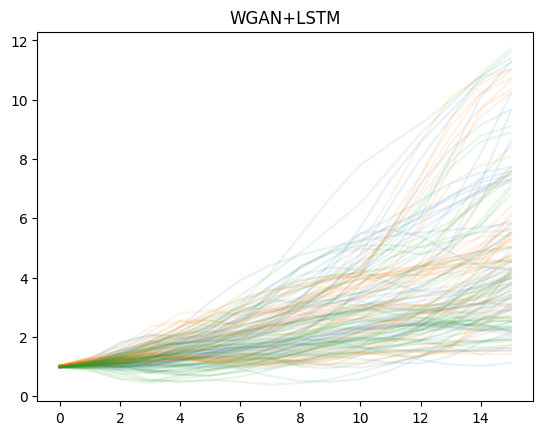

In [14]:
with torch.no_grad():
    wgan_lstm_fake = LSTM_WGAN.G(500, 16, wgan_config['device'])

for i in range(x_real_dim):
    plt.plot(to_numpy(wgan_lstm_fake[:50, :, i]).T, 'C%s' %i, alpha=0.1)
plt.title("WGAN+LSTM")
plt.show()

torch.Size([200, 16])


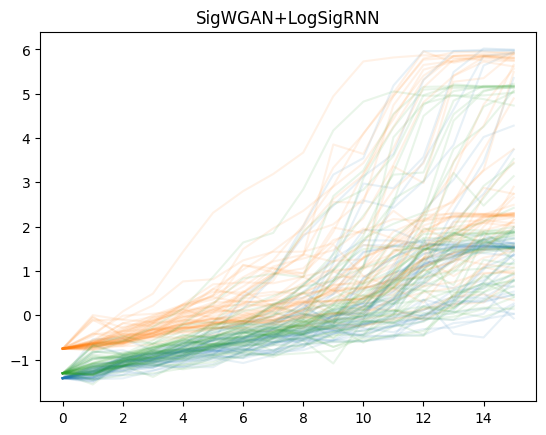

In [ ]:
with torch.no_grad():
    sigwgan_logsig_fake = logsig_SigWGAN.G(200, 16, sigwgan_config['device'])

for i in range(x_real_dim):
    plt.plot(to_numpy(sigwgan_logsig_fake[:50, :, i]).T, 'C%s' % i, alpha=0.1)
print(sigwgan_logsig_fake[:200, :, i].shape)
plt.title("SigWGAN+LogSigRNN")
plt.show()

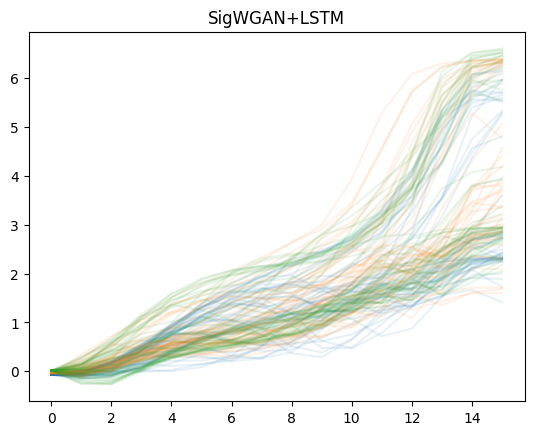

In [ ]:
with torch.no_grad():
    sigwgan_lstm_fake = lstm_SigWGAN.G(500, 16, sigwgan_config['device'])

for i in range(x_real_dim):
    plt.plot(to_numpy(sigwgan_lstm_fake[:50, :, i]).T, 'C%s' %i, alpha=0.1)
plt.title("SigWGAN+LSTM")
plt.show()

### Numerical results: WGAN

#### WGAN+LogSigRNN

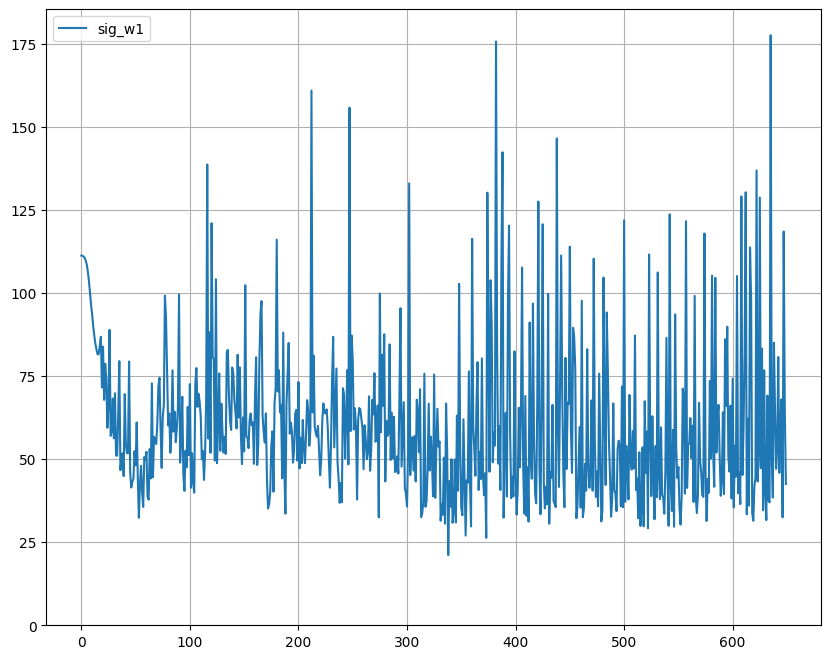

In [11]:
plot_test_metrics(test_metrics=Logsig_WGAN.test_metrics_test,losses_history=Logsig_WGAN.losses_history,mode="test")

<AxesSubplot:title={'center':'WGAN+LogSigRNN'}, ylabel='pdf'>

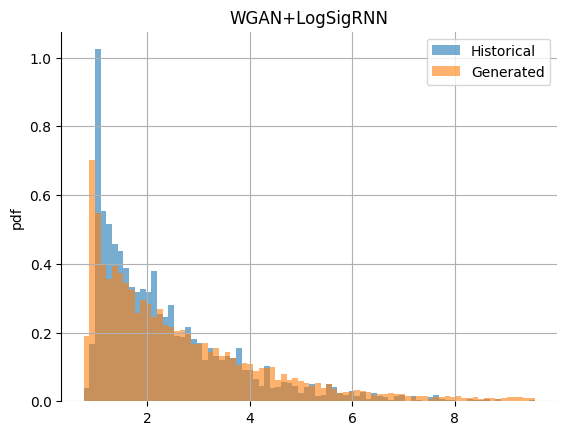

In [13]:
compare_hists(to_numpy(GBM_paths[:50]),to_numpy(wgan_logsig_fake),trainer="WGAN",G="LogSigRNN")

#### WGAN+LSTM

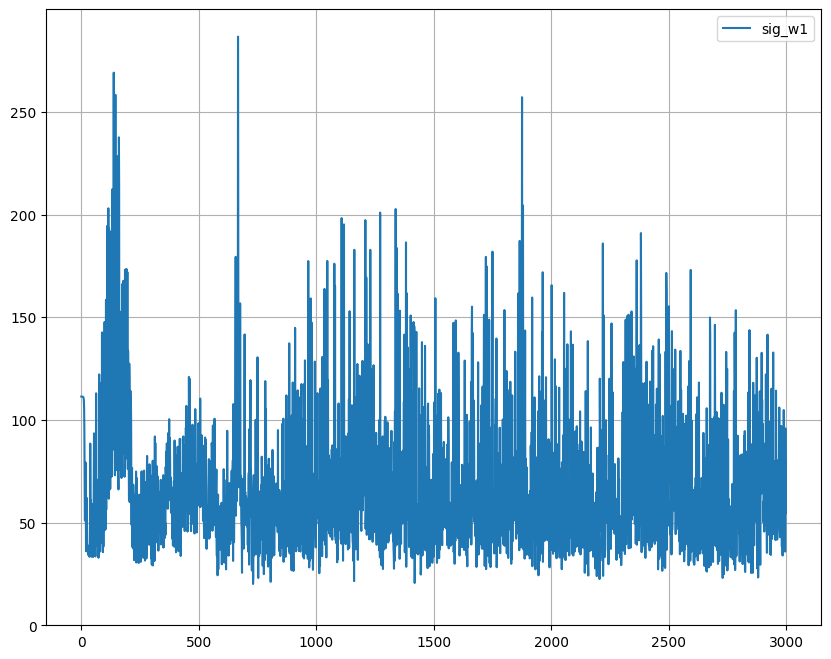

In [11]:
plot_test_metrics(test_metrics=LSTM_WGAN.test_metrics_test,losses_history=LSTM_WGAN.losses_history,mode="test")

<AxesSubplot:title={'center':'WGAN+LSTM'}, ylabel='pdf'>

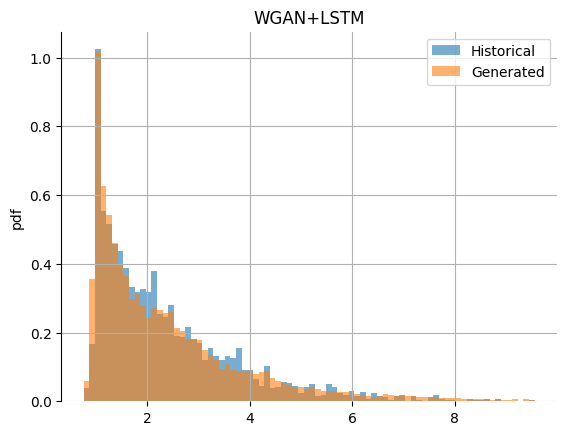

In [15]:
compare_hists(to_numpy(GBM_paths[:50]),to_numpy(wgan_lstm_fake),trainer="WGAN",G="LSTM")

#### SigWGAN+LogSigRNN

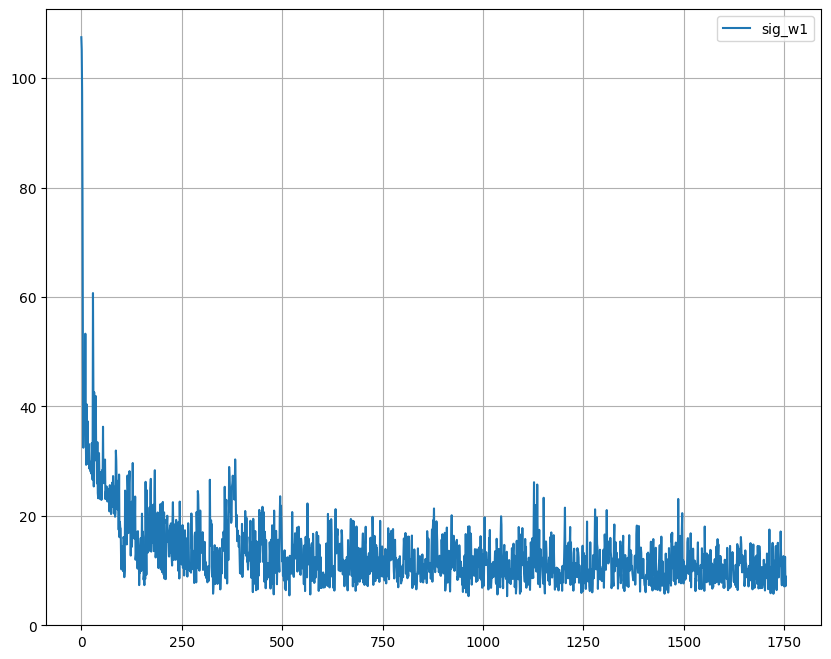

In [ ]:
plot_test_metrics(test_metrics=logsig_SigWGAN.test_metrics_test,losses_history=logsig_SigWGAN.losses_history,mode="test")

<AxesSubplot:title={'center':'SigWGAN+LogSigRNN'}, ylabel='pdf'>

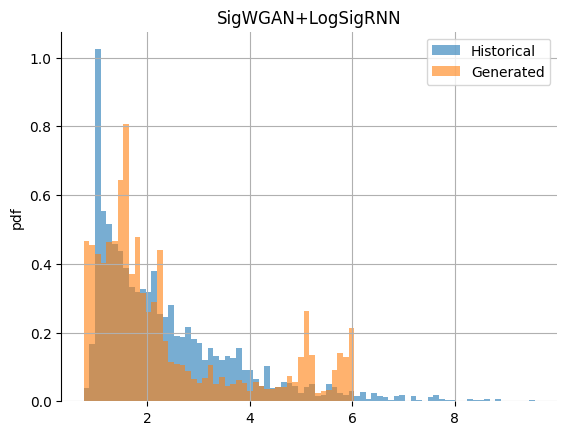

In [ ]:
compare_hists(to_numpy(GBM_paths[:50]),to_numpy(sigwgan_logsig_fake),trainer="SigWGAN",G="LogSigRNN")

#### SigWGAN+LSTM

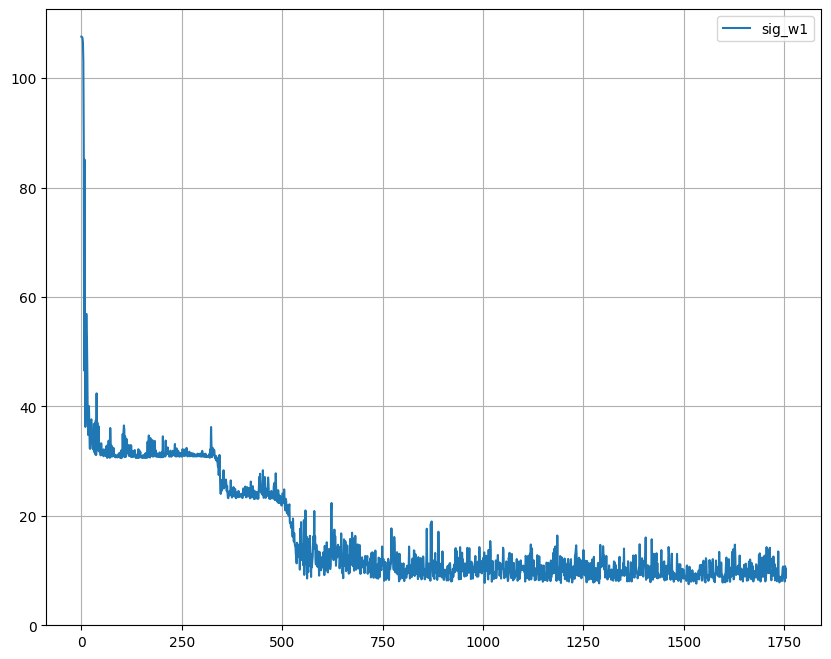

In [ ]:
plot_test_metrics(test_metrics=lstm_SigWGAN.test_metrics_test,losses_history=lstm_SigWGAN.losses_history,mode="test")

<AxesSubplot:title={'center':'SigWGAN+LSTM'}, ylabel='pdf'>

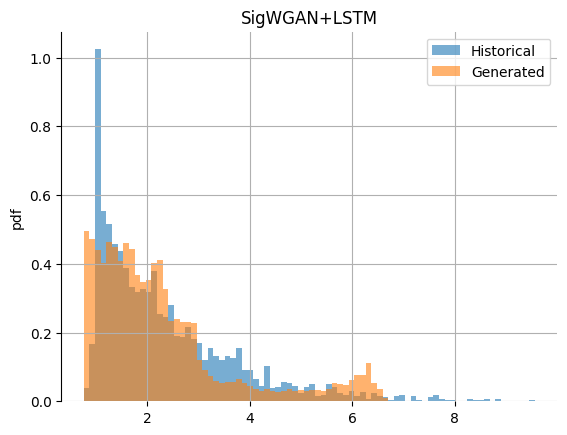

In [ ]:
compare_hists(to_numpy(GBM_paths[:50]),to_numpy(sigwgan_lstm_fake),trainer="SigWGAN",G="LSTM")